In [37]:
import cv2
import os 
import matplotlib.pyplot as plt
import numpy as np 
from random import shuffle 
keras.utils.np_utils.to_categorical
import pandas as pd
LR = 1e-3
IMG_SIZE = 150
NUM_LABELS = 4

In [38]:
labels_df = pd.read_csv('C://Users//lvyue//Desktop//ML/oasis_cross-sectional.csv')
labels_df = labels_df.drop(columns=['M/F','Hand','Age','Educ','SES','MMSE','eTIV','nWBV','ASF','Delay'])
labels_df = labels_df.fillna(0)
labels_df.head()

,ID,CDR
0,OAS1_0001_MR1,0.0
1,OAS1_0002_MR1,0.0
2,OAS1_0003_MR1,0.5
3,OAS1_0004_MR1,0.0
4,OAS1_0005_MR1,0.0


In [39]:
TRAIN_DIR = 'F:\\masked_gfc_imgs'

In [40]:
'''Setting up the model which will help with tensorflow models'''
MODEL_NAME = 'Alzheimer-{}-{}.model'.format(LR, '6conv-basic') 
  
'''Labelling the dataset'''

y_train_test = []
training_test_data = [] 
for img in tqdm(os.listdir(TRAIN_DIR)):
    path = os.path.join(TRAIN_DIR, img)
    imgs = np.fromfile(path, dtype=np.int16)
    if len(imgs)==6443008:
        names = img.split('_mpr')[0]
        imgs = imgs.reshape(176,208,176)
        imgs = cv2.resize(imgs, (IMG_SIZE,IMG_SIZE))
        for j in range(40,90):
            images = imgs[:,:,j]
            training_test_data.append(np.array(images))
            for i in range(0,436):
                if list(labels_df['ID'])[i]== names:
                    labels = list(labels_df['CDR'])[i]
                    y_train_test.append(np.array(labels))
            
            #print("index is", i,"CDR is",label)
            
np.save('train_test_data_slices.npy',  training_test_data)  
np.save('y_data_slices.npy',  y_train_test)             

    
    # DIY One hot encoder 
    #if labels == 0.0: return [1, 0, 0, 0, 0] 
    #elif labels == 0.5: return [0, 1, 0, 0, 0]
    #elif labels ==1.0: return [0, 0, 1, 0, 0]
    #elif labels ==1.5: return [0, 0, 0, 1, 0]
    #elif labels ==2.0: return [0, 0, 1, 0, 1]

100%|████████████████████████████████████████████████████████████████████████████████| 437/437 [17:20<00:00,  2.38s/it]


In [79]:
y_train_test = np.load('y_data_slices.npy')
training_test_data = np.load('train_test_data_slices.npy')

In [80]:
y_train = np.asarray(y_train_test[:360])
y_test = np.asarray(y_train_test[360:])
print(y_test.size)

21440


In [81]:
x_train = np.asarray(training_test_data[:360])
x_test = np.asarray(training_test_data[360:])
print(x_test.size)
X_train = x_train.reshape(-1,IMG_SIZE*IMG_SIZE)
X_test = x_test.reshape(-1,IMG_SIZE*IMG_SIZE)
print(X_test.shape)
print(X_train.shape[0])

482400000
(21440, 22500)
360


In [82]:
## Data
# one-hot encoding:
y_train_OH = np_utils.to_categorical(y_train, NUM_LABELS)
y_test_OH = np_utils.to_categorical(y_test, NUM_LABELS)
print(y_test_OH.shape)

(21440, 4)


In [69]:
from keras.layers.core import Dense, Activation, Dropout
from keras.models import Sequential
model = Sequential()
model.add(Dense(128, input_shape=(IMG_SIZE*IMG_SIZE,),activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Activation('softmax'))


In [70]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

epochs = 15

history = model.fit(X_train, 
                    y_train_OH, 
                    epochs=epochs, 
                    batch_size=256,
                    verbose=1,
                    validation_data=(X_test, y_test_OH))

Instructions for updating:
Use tf.cast instead.
Train on 320 samples, validate on 21480 samples
Epoch 1/15
320/320 [==============================] - ETA: 0s - loss: 10.5815 - acc: 0.32 - 9s 28ms/step - loss: 10.5103 - acc: 0.3312 - val_loss: 9.4747 - val_acc: 0.4138
Epoch 2/15
320/320 [==============================] - ETA: 0s - loss: 10.5240 - acc: 0.32 - 6s 20ms/step - loss: 10.5103 - acc: 0.3312 - val_loss: 9.4747 - val_acc: 0.4138
Epoch 3/15
320/320 [==============================] - ETA: 0s - loss: 10.5870 - acc: 0.32 - 6s 20ms/step - loss: 10.5103 - acc: 0.3312 - val_loss: 9.4747 - val_acc: 0.4138
Epoch 4/15
320/320 [==============================] - ETA: 0s - loss: 10.5132 - acc: 0.33 - 6s 20ms/step - loss: 10.5103 - acc: 0.3312 - val_loss: 9.4747 - val_acc: 0.4138
Epoch 5/15
320/320 [==============================] - ETA: 0s - loss: 10.5348 - acc: 0.32 - 6s 20ms/step - loss: 10.5103 - acc: 0.3312 - val_loss: 9.4747 - val_acc: 0.4138
Epoch 6/15
320/320 [========================

KeyboardInterrupt: 

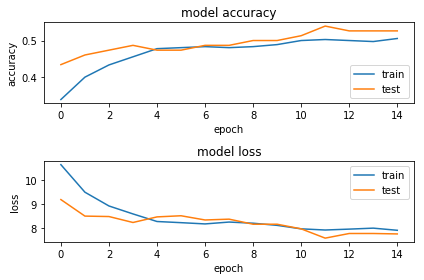

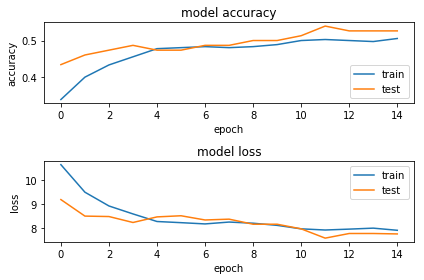

In [10]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

fig

In [83]:
# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, IMG_SIZE, IMG_SIZE).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, IMG_SIZE, IMG_SIZE).astype('float32')
print(X_train.shape)
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
print(X_train.shape)

(360, 1, 150, 150)
(360, 1, 150, 150)


In [72]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')
# fix random seed for reproducibility
seed = 42
numpy.random.seed(seed)

In [84]:
def larger_model():
	# create model
	model = Sequential()
	model.add(Conv2D(32, (5, 5), input_shape=(1,IMG_SIZE,IMG_SIZE), activation='relu'))
	model.add(MaxPooling2D(pool_size=(3, 3)))
	model.add(Conv2D(16, (3, 3), activation='relu'))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(128, activation='relu'))
	model.add(Dense(64, activation='relu'))
	model.add(Dense(4, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [85]:
# build the model
model = larger_model()

In [87]:
# Fit the model
model.fit(X_train, y_train_OH, validation_data=(X_test, y_test_OH), epochs=10, batch_size=200)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test_OH, verbose=1)
print("Large CNN Error: %.2f%%" % (100-scores[1]*100))

Train on 360 samples, validate on 21440 samples
Epoch 1/10
200/360 [===============>..............] - ETA: 5s - loss: 3.9489 - acc: 0.7550

KeyboardInterrupt: 

In [45]:
score = model.evaluate(X_test, y_test_OH, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5759852952078769
Test accuracy: 0.7894736873476129


In [46]:
import os
# saving the model
SAVE_DIR = "./"
MODEL_NAME = 'my_model_weights_slicesz.h5'
model_path = os.path.join(SAVE_DIR, MODEL_NAME)

model.save(model_path)
#print('Saved trained model at %s ' % model_path)
from keras.models import load_model
model = load_model(model_path)

In [30]:
import skimage